# Time Series Classification and Clustering Assignment

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

### Import the Walmart stock price data set (WMT_data.csv).

In [2]:
df = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%205/WMT_data.csv')

In [3]:
df

,date,open,high,low,close,volume,Name
0,2013-02-08,71.20,71.64,71.070,71.48,5906823,WMT
1,2013-02-11,71.25,71.51,70.530,71.40,6202534,WMT
2,2013-02-12,71.49,71.66,71.100,71.40,4761910,WMT
3,2013-02-13,71.29,71.70,71.210,71.39,3969807,WMT
4,2013-02-14,71.10,71.23,70.755,70.82,6820952,WMT
...,...,...,...,...,...,...,...
1254,2018-02-01,105.96,106.56,105.180,105.52,6386836,WMT
1255,2018-02-02,105.15,106.47,104.150,104.48,9253068,WMT
1256,2018-02-05,103.40,104.61,97.090,100.09,12561594,WMT
1257,2018-02-06,97.64,101.08,97.250,100.90,16413797,WMT


### Transform the data to be able to predict minor direction changes in the stock's price, given 180 days of history.

- Remember to calculate daily returns from the observed values (closing price).
- Make the critera for identifying a direction change when the observed values (closing price) cross the 5 day moving average.
- Create a binary column that defaults to 0 unless the criteria is met (then updates to 1).
- Shift the data set so that you have 180 days of history for each record.

In [8]:
df['return'] = (df['close'] - df['close'].shift()) / df['close'].shift()
df['MA_5'] = df['close'].rolling(5).mean()
df['Trend'] = 0
df.loc[(df['MA_5'] < df['close']), 'Trend'] = 1

transformed = df[['date', 'return', 'Trend']]

history = 90
future = 0

shifts = [x + future for x in list(range(1, history + 1))]

for shift in shifts:
    transformed['t-' + str(shift)] = transformed['return'].shift(shift)

transformed.dropna(inplace=True)
transformed.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,return,Trend,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30,t-31,t-32,t-33,t-34,t-35,t-36,t-37,...,t-51,t-52,t-53,t-54,t-55,t-56,t-57,t-58,t-59,t-60,t-61,t-62,t-63,t-64,t-65,t-66,t-67,t-68,t-69,t-70,t-71,t-72,t-73,t-74,t-75,t-76,t-77,t-78,t-79,t-80,t-81,t-82,t-83,t-84,t-85,t-86,t-87,t-88,t-89,t-90
91,2013-06-20,-0.019205,0,-0.016770,0.010407,0.001069,-0.001733,0.002138,-0.005449,-0.006601,-0.007599,0.009256,0.005050,-0.009086,0.003303,0.011358,-0.010446,-0.007871,-0.014097,0.000129,0.012839,-0.009087,-0.004652,-0.000129,-0.006036,-0.008025,-0.017030,0.013709,0.003567,-0.004944,0.006250,0.001917,-0.007358,0.000000,-0.005300,0.010069,0.005124,0.004375,-0.008547,-0.008224,...,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463,-0.007984,-0.000140,0.000000,-0.001119
92,2013-06-21,0.006573,0,-0.019205,-0.016770,0.010407,0.001069,-0.001733,0.002138,-0.005449,-0.006601,-0.007599,0.009256,0.005050,-0.009086,0.003303,0.011358,-0.010446,-0.007871,-0.014097,0.000129,0.012839,-0.009087,-0.004652,-0.000129,-0.006036,-0.008025,-0.017030,0.013709,0.003567,-0.004944,0.006250,0.001917,-0.007358,0.000000,-0.005300,0.010069,0.005124,0.004375,-0.008547,...,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463,-0.007984,-0.000140,0.000000
93,2013-06-24,0.009386,1,0.006573,-0.019205,-0.016770,0.010407,0.001069,-0.001733,0.002138,-0.005449,-0.006601,-0.007599,0.009256,0.005050,-0.009086,0.003303,0.011358,-0.010446,-0.007871,-0.014097,0.000129,0.012839,-0.009087,-0.004652,-0.000129,-0.006036,-0.008025,-0.017030,0.013709,0.003567,-0.004944,0.006250,0.001917,-0.007358,0.000000,-0.005300,0.010069,0.005124,0.004375,...,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463,-0.007984,-0.000140
94,2013-06-25,0.002291,1,0.009386,0.006573,-0.019205,-0.016770,0.010407,0.001069,-0.001733,0.002138,-0.005449,-0.006601,-0.007599,0.009256,0.005050,-0.009086,0.003303,0.011358,-0.010446,-0.007871,-0.014097,0.000129,0.012839,-0.009087,-0.004652,-0.000129,-0.006036,-0.008025,-0.017030,0.013709,0.003567,-0.004944,0.006250,0.001917,-0.007358,0.000000,-0.005300,0.010069,0.005124,...,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463,-0.007984
95,2013-06-26,0.008606,1,0.002291,0.009386,0.006573,-0.019205,-0.016770,0.010407,0.001069,-0.001733,0.002138,-0.005449,-0.006601,-0.007599,0.009256,0.005050,-0.009086,0.003303,0.011358,-0.010446,-0.007871,-0.014097,0.000129,0.012839,-0.009087,-0.004652,-0.000129,-0.006036,-0.008025,-0.017030,0.013709,0.003567,-0.004944,0.006250,0.001917,-0.007358,0.000000,-0.005300,0.010069,...,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833

### Train a Logistic Regression classification model on the transformed data.

In [11]:
x = transformed.drop(['date', 'return', 'Trend'], axis=1)
y = transformed['Trend']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle=False)

model = LogisticRegression(class_weight='balanced')
model.fit(x_train, y_train)
predictions = model.predict(x_test)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Run a classification report and evaluate the performance of the classifier.

In [12]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64        91
           1       0.77      0.76      0.77       143

    accuracy                           0.72       234
   macro avg       0.70      0.71      0.70       234
weighted avg       0.72      0.72      0.72       234



### Transform the data again to have 10 days of history for clustering.

In [2]:
transformed1 = df[['date', 'return', 'Trend']]

history = 10
future = 0

shifts = [x + future for x in list(range(1, history + 1))]

for shift in shifts:
    transformed1['t-' + str(shift)] = transformed1['return'].shift(shift)

transformed1.dropna(inplace=True)
transformed1.head()

### Train a K Means clustering model on the data. 

Try different values for K and see how the summary changes.

In [13]:
def kmeans(df, clusters=2):
    model = KMeans(n_clusters=clusters, random_state=42)
    clusters = model.fit_predict(df)
    results = df.copy()
    results['Cluster'] = clusters
    
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    
    return results, summary

results, summary = kmeans(x, clusters=8)
summary

,Cluster,Count,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30,t-31,t-32,t-33,t-34,t-35,t-36,t-37,t-38,...,t-51,t-52,t-53,t-54,t-55,t-56,t-57,t-58,t-59,t-60,t-61,t-62,t-63,t-64,t-65,t-66,t-67,t-68,t-69,t-70,t-71,t-72,t-73,t-74,t-75,t-76,t-77,t-78,t-79,t-80,t-81,t-82,t-83,t-84,t-85,t-86,t-87,t-88,t-89,t-90
0,0,159,0.002692,-0.000628,0.003950,0.004050,0.001226,-0.001994,-0.001302,0.000902,-0.000654,-0.002576,0.000524,-0.000144,0.003503,0.000712,0.002880,0.000211,-0.004804,0.000333,0.001625,-0.000121,-0.003457,0.001019,0.001120,-0.001243,0.005330,-0.000785,-0.000081,0.000430,0.002834,-0.000090,-0.001012,0.004332,-0.001861,-0.000781,0.003967,-0.000886,0.000243,-0.002459,...,0.002960,0.000528,-0.002782,0.000591,0.005456,-0.001611,-0.002664,0.004498,0.001014,0.000299,-0.001079,-0.000893,0.002125,0.000140,0.003348,0.001126,-0.001377,0.000749,0.001413,-0.002245,-0.001588,-0.000048,-0.000337,-0.002942,0.001773,0.001454,-0.000096,-0.000530,0.004113,-0.000699,0.001107,0.002919,-0.002603,-0.000771,-0.000135,0.001592,0.003149,-0.001984,0.001224,0.000141
1,1,297,-0.000595,-0.001032,0.002035,-0.002877,-0.000028,-0.000737,0.003322,0.000070,0.000330,-0.000967,0.001072,0.000053,0.001895,-0.001652,-0.001237,-0.001357,0.004375,0.000109,-0.000552,-0.001811,0.002931,-0.001580,0.003822,-0.001194,0.000249,0.000187,0.000022,-0.001828,0.000623,-0.001177,0.000616,-0.002461,0.002464,-0.000420,0.001845,0.000229,-0.001929,-0.001735,...,0.000260,-0.000051,0.000935,-0.002586,-0.000077,-0.000602,0.002902,-0.001880,0.001358,-0.001319,0.000839,0.000873,0.001292,-0.002319,0.000130,-0.000648,0.002305,-0.000656,0.000904,0.001013,0.002039,-0.001415,0.000977,-0.000290,0.001872,-0.001390,0.000461,-0.001428,0.000938,-0.002142,-0.000513,-0.001801,0.001543,0.000464,0.003169,0.000258,0.000356,-0.001478,0.001286,-0.002481
2,2,202,0.000291,0.005397,-0.000772,0.001179,-0.002913,-0.000658,-0.003213,-0.001689,0.001960,0.002220,0.000894,0.004646,-0.003071,-0.000643,-0.001705,0.000646,-0.000395,-0.001922,-0.000937,0.001890,-0.000918,0.000189,-0.002402,-0.000380,-0.000848,0.000089,0.001484,0.001719,-0.001434,0.000221,-0.000846,0.000763,0.001244,0.001147,-0.001100,0.003240,-0.000973,0.003465,...,-0.000934,0.001168,-0.001095,0.003532,-0.001253,0.001612,-0.003683,-0.001255,-0.000837,0.001323,-0.000644,0.000702,-0.000413,0.003323,0.002683,-0.000776,-0.003186,0.000637,-0.003192,0.001848,-0.001073,0.003400,0.000179,0.001203,-0.000175,-0.000489,0.001294,0.000203,-0.003082,0.001221,-0.001419,0.000045,0.001945,0.002018,-0.001053,0.000360,-0.000301,0.002378,-0.002439,0.000755
3,3,82,0.001134,-0.004387,-0.002896,0.004193,0.006451,0.006570,-0.000442,-0.001173,0.000868,-0.000650,0.001835,-0.004092,-0.000374,0.000566,0.010868,-0.000937,-0.000063,-0.000679,-0.001809,-0.002787,0.001234,0.007073,-0.000540,0.001944,0.002935,-0.001006,0.001824,-0.002993,-0.003047,-0.001237,0.009661,0.002224,0.002166,0.002374,-0.000379,-0.004378,0.000191,0.004211,...,0.002177,-0.003258,-0.000145,0.004579,-0.000009,-0.003019,0.002894,0.000798,0.001291,-0.002304,0.001725,-0.002028,-0.000654,-0.003572,0.002402,-0.001169,0.005857,-0.001915,0.000017,-0.000328,-0.002184,-0.000786,-0.000913,0.000925,0.002520,0.001650,0.003626,-0.001425,-0.001531,0.002941,-0.000059,-0.003631,0.003281,-0.000370,0.003314,-0.002772,-0.000133,0.002564,-0.005657,0.003218
4,4,126,-0.002937,0.002139,-0.004237,-0.002271,-0.002375,0.004067,0.001130,0.004384,-0.000504,-0.001197,-0.002602,0.000168,0.000115,-0.001451,-0.000119,0.000895,-0.000348,0.005341,-0.001653,-0.001479,-0.000573,0.002281,-0.000930,0.002152,-0.000620,-0.001181,-0.004805,-0.000783,0.002887,-0.001935,0.000911,0.002537,-0.001830,-0.000697,-0.001910,-0.000986,-0.000663,0.000585,...,-0.002070,0.005116,0.001015,-0.002302,-0.002067,0.001805,-0.001791,0.002507,-0.003206,0.000909,0.001941,0.000571,-0.002397,0.000675,-0.002789,-0.000993,-0.003780,0.004854,0.004811,-0.000276,0.001835,0.000590,-0.0010

### Visualize the summary of the clustering results as a heatmap.

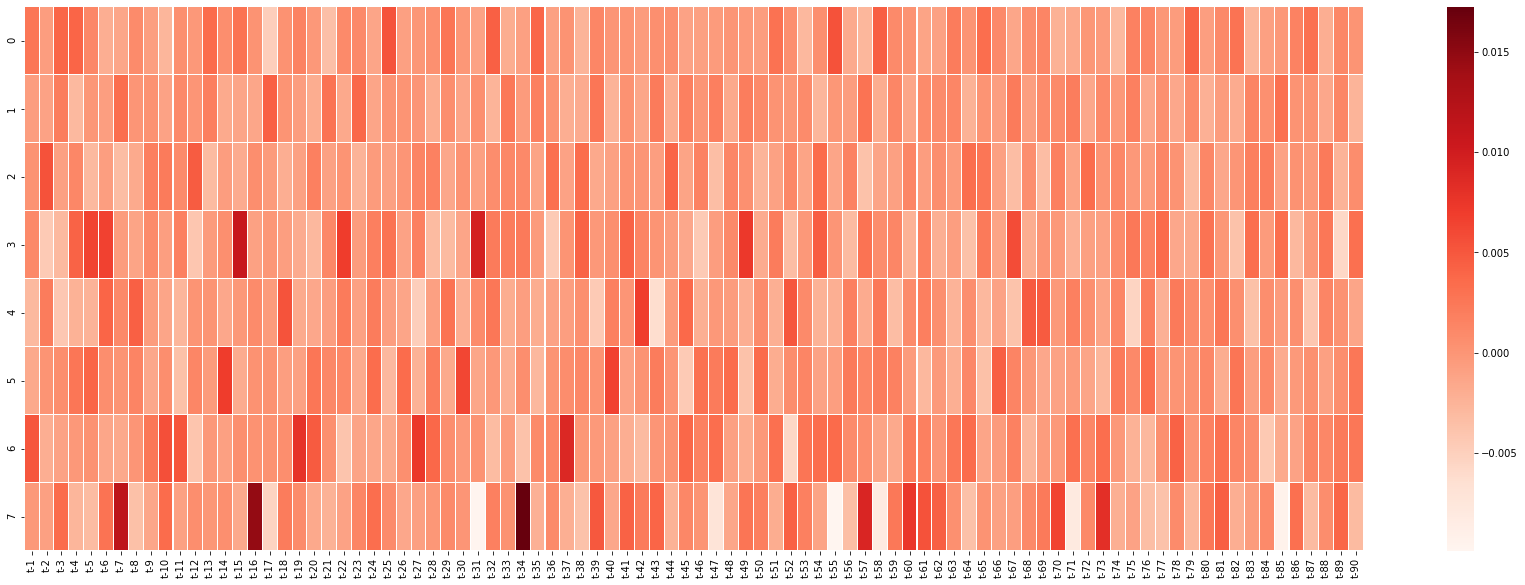

In [15]:
plt.figure(figsize=(30,10))
sns.heatmap(summary.drop(columns=['Cluster', 'Count']), cmap='Reds', linewidths=0.01)